In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# @title Проверка q_labels_matching.py
import numpy as np
import pandas as pd

from drive.MyDrive.stocks.pretrained_rl_ppo.scr.q_labels_matching import next_exit_exec_arrays, enrich_q_labels_trend_one_side

# ---------------------------
# Вспомогательные генераторы
# ---------------------------

def _mk_df(open_, high=None, low=None, close=None, sig=None):
    n = len(open_)
    return pd.DataFrame({
        'Open':  np.asarray(open_, dtype=float),
        'High':  np.asarray(high  if high  is not None else open_, dtype=float),
        'Low':   np.asarray(low   if low   is not None else open_, dtype=float),
        'Close': np.asarray(close if close is not None else open_, dtype=float),
        'Signal_Rule': np.asarray(sig if sig is not None else np.zeros(n, dtype=int)),
    })


# ---------------------------
# next_exit_exec_arrays
# ---------------------------

def test_exit_execution_is_next_open_long():
    """
    Сигнал выхода (sell) в t=2 -> исполнение на t=3 (Open[3]).
    Для t=0 ближайший исполняемый exit должен быть e=3.
    """
    open_px = np.array([10., 11., 12., 13., 14.])
    sell = np.array([0,0,1,0,0], dtype=bool)
    buy  = np.array([0,0,0,0,0], dtype=bool)
    idx, px = next_exit_exec_arrays(open_px, buy, sell, side_long=True)
    assert idx[0] == 3
    assert px[0]  == open_px[3]


def test_exit_execution_is_next_open_short():
    """
    В short-only выходом считается buy-сигнал.
    """
    open_px = np.array([100., 90., 80., 85., 70.])
    buy  = np.array([0,0,1,0,0], dtype=bool)   # buy@2 -> exec@3
    sell = np.array([0,0,0,0,0], dtype=bool)
    idx, px = next_exit_exec_arrays(open_px, buy, sell, side_long=False)
    assert idx[0] == 3
    assert px[0]  == open_px[3]


# ---------------------------
# mode='exit'
# ---------------------------

def test_exit_mode_hold_uses_exec_next_open_price():
    """
    buy@0 (exec t=1), sell@2 (exec t=3).
    На t=1 позиция уже открыта, поэтому:
    Hold(t=1) = Open[3]/Open[2]-1 = 120/110 - 1
    """
    open_px = np.array([100., 105., 110., 120.])
    sig     = np.array([+1, 0, -1, 0])  # buy на t=0, sell на t=2
    df = _mk_df(open_px, sig=sig)

    out = enrich_q_labels_trend_one_side(
        df, mode='exit', side_long=True, fee_bps=0, slippage_bps=0
    )

    assert out.loc[0, 'Mask_Hold'] == 0  # на t=0 позиции ещё нет
    assert out.loc[1, 'Mask_Hold'] == 1
    np.testing.assert_allclose(out.loc[1, 'Q_Hold'], 120/110 - 1, rtol=1e-7)


def test_exit_mode_open_includes_both_fees_long():
    """
    В Open должны применяться издержки и на вход, и на выход.
    """
    open_px = np.array([100., 110., 121., 121.])  # рост ~10% затем ~10%
    sig     = np.array([0, 0, -1, 0])             # sell@2 -> exec@3
    df = _mk_df(open_px, sig=sig)

    fee = 10.0   # 10 bps
    slp = 20.0   # 20 bps
    c = (fee + slp) * 1e-4

    out = enrich_q_labels_trend_one_side(
        df, mode='exit', side_long=True, fee_bps=fee, slippage_bps=slp
    )
    # На t=0 flat, has exit -> Open валиден
    assert out.loc[0, 'Mask_Open'] == 1
    # Теоретическое ожидание:
    # entry_eff = Open[1] * (1 + c) = 110*(1+c)
    # exit_eff  = Open[3] * (1 - c) = 121*(1-c)
    expected = (121*(1-c)) / (110*(1+c)) - 1.0
    np.testing.assert_allclose(out.loc[0, 'Q_Open'], expected, rtol=1e-7)


def test_exit_mode_long_short_symmetry_open_hold():
    """
    Симметрия Open для long/short при mode='exit' без комиссий:
    R_long = O[exec_exit]/O[exec_entry] - 1
    R_short= O[exec_entry]/O[exec_exit] - 1 = 1/(1+R_long) - 1
    """
    open_px = np.array([100., 90., 80., 120., 110.])

    # LONG: exit определяется sell-сигналом -> sell@2 => exec@3
    sig_long = np.array([0, 0, -1, 0, 0])
    df_long  = _mk_df(open_px, sig=sig_long)
    out_long = enrich_q_labels_trend_one_side(df_long, mode='exit', side_long=True, fee_bps=0, slippage_bps=0)

    # SHORT: exit определяется buy-сигналом -> buy@2 => exec@3
    sig_short = np.array([0, 0, +1, 0, 0])
    df_short  = _mk_df(open_px, sig=sig_short)
    out_short = enrich_q_labels_trend_one_side(df_short, mode='exit', side_long=False, fee_bps=0, slippage_bps=0)

    # t=0: оба действия Open валидны (есть будущий exec-выход >= t+2)
    assert out_long.loc[0,'Mask_Open'] == 1
    assert out_short.loc[0,'Mask_Open'] == 1

    R_long  = out_long.loc[0,'Q_Open']
    R_short = out_short.loc[0,'Q_Open']
    # Проверяем точную взаимосвязь (без комиссий):
    # R_short == 1/(1+R_long) - 1
    np.testing.assert_allclose(R_short, 1.0/(1.0 + R_long) - 1.0, rtol=1e-7)

    # Для Hold симметрия зависит от факта наличия позиции; валидность масок допустима 0/1
    assert out_long.loc[1,'Mask_Hold'] in (0,1)
    assert out_short.loc[1,'Mask_Hold'] in (0,1)


# ---------------------------
# mode='horizon'
# ---------------------------

def test_horizon_basic_open_hold_long():
    """
    H=2: Open(t=0) = Open[2]/Open[1]-1; Hold(t=1) = Open[3]/Open[2]-1.
    """
    open_px = np.array([100., 110., 121., 133.1])
    df = _mk_df(open_px)

    out = enrich_q_labels_trend_one_side(df, mode='horizon', horizon=2,
                                         side_long=True, fee_bps=0, slippage_bps=0)
    assert out.loc[0, 'Mask_Open'] == 1
    np.testing.assert_allclose(out.loc[0, 'Q_Open'], 121/110 - 1, rtol=1e-7)

    # Чтобы Hold на t=1 был валиден, позиция должна быть открыта к t=1:
    sig = np.array([+1, 0, 0, 0])
    df2 = _mk_df(open_px, sig=sig)
    out2 = enrich_q_labels_trend_one_side(df2, mode='horizon', horizon=2,
                                          side_long=True, fee_bps=0, slippage_bps=0)
    assert out2.loc[1, 'Mask_Hold'] == 1
    np.testing.assert_allclose(out2.loc[1, 'Q_Hold'], 133.1/121 - 1, rtol=1e-7)


def test_horizon_commissions_monotonicity_open():
    """
    Рост комиссий не должен увеличивать Q_Open.
    """
    open_px = np.array([100., 110., 120., 130.])
    df = _mk_df(open_px)

    out_low_fee = enrich_q_labels_trend_one_side(df, mode='horizon', horizon=2,
                                                 side_long=True, fee_bps=1.0, slippage_bps=1.0)
    out_hi_fee  = enrich_q_labels_trend_one_side(df, mode='horizon', horizon=2,
                                                 side_long=True, fee_bps=20.0, slippage_bps=20.0)
    idx = np.where(out_low_fee['Mask_Open'] == 1)[0]
    assert len(idx) > 0
    assert all(out_hi_fee.loc[i, 'Q_Open'] <= out_low_fee.loc[i, 'Q_Open'] for i in idx)


# ---------------------------
# mode='tdlambda'
# ---------------------------

def test_tdlambda_weighted_average_open_long():
    """
    TD(λ): Q_Open — средневзвешенная смесь n-step возвратов.
    Проверяем, что при константном росте значения разумные и маска корректна.
    """
    open_px = np.array([100., 101., 102., 103., 104., 105.])
    df = _mk_df(open_px)
    out = enrich_q_labels_trend_one_side(df, mode='tdlambda', H_max=3, lam=0.5,
                                         side_long=True, fee_bps=0, slippage_bps=0)
    # t=0: доступны n=1..3 → маска валидна
    assert out.loc[0, 'Mask_Open'] == 1
    assert not np.isnan(out.loc[0, 'Q_Open'])


def test_tdlambda_mae_penalty_decreases_hold():
    """
    Создаём неблагоприятный дип в Low — штраф MAE должен уменьшать Q_Hold (при валидной позиции).
    """
    N = 12
    open_px = np.full(N, 100.0)
    high_px = np.full(N, 101.0)
    low_px  = np.full(N, 100.0)
    low_px[4] = 90.0   # дип

    sig = np.zeros(N, dtype=int)
    sig[0] = +1        # buy@0 -> pos с t=1
    sig[10] = -1       # sell@10 -> exec@11

    df = _mk_df(open_px, high=high_px, low=low_px, sig=sig)

    out_pen = enrich_q_labels_trend_one_side(df, mode='tdlambda', H_max=6, lam=0.9,
                                             side_long=True, use_mae_penalty=True, mae_lambda=0.5,
                                             mae_apply_to='hold', fee_bps=0, slippage_bps=0)
    out_nop = enrich_q_labels_trend_one_side(df, mode='tdlambda', H_max=6, lam=0.9,
                                             side_long=True, use_mae_penalty=False,
                                             fee_bps=0, slippage_bps=0)
    # Возьмём индексы, где Hold валиден
    idxs = np.where((out_pen['Mask_Hold']==1) & (out_nop['Mask_Hold']==1))[0]
    assert len(idxs) > 0
    assert any(out_pen.loc[i, 'Q_Hold'] < out_nop.loc[i, 'Q_Hold'] for i in idxs)


def test_tdlambda_masks_invalid_when_no_future():
    """
    Если для строки нет ни одного валидного будущего барра (все fut NaN),
    маски Open/Hold должны быть 0, а Q — NaN.
    """
    open_px = np.array([10., 11., np.nan, np.nan])
    df = _mk_df(open_px)

    out = enrich_q_labels_trend_one_side(df, mode='tdlambda', H_max=3, side_long=True)
    # Последний бар точно невалиден
    last = len(df) - 1
    assert out.loc[last, 'Mask_Open'] == 0
    assert out.loc[last, 'Mask_Hold'] == 0
    assert np.isnan(out.loc[last, 'Q_Open'])
    assert np.isnan(out.loc[last, 'Q_Hold'])

    # Для любой строки с Mask_Open==1 — Q_Open обязан быть числом
    idx_valid = np.where(out['Mask_Open'] == 1)[0]
    assert all(~pd.isna(out.loc[idx_valid, 'Q_Open']))


# ---------------------------
# NaN / граничные случаи
# ---------------------------

def test_nan_inputs_propagate_to_q_and_masks():
    """
    Если Open[t+1] = NaN — действия, зависящие от exec_next_open, невалидны.
    """
    open_px = np.array([100., np.nan, 110., 120.])
    df = _mk_df(open_px)

    out = enrich_q_labels_trend_one_side(df, mode='horizon', horizon=2,
                                         side_long=True, fee_bps=0, slippage_bps=0)
    # На t=0 exec_next_open = Open[1] = NaN -> Open/Wait только маска Wait=1, Open=0
    assert out.loc[0, 'Mask_Open'] == 0 or np.isnan(out.loc[0, 'Q_Open'])
    # На последних барах без будущего горизонта маска Open=0
    assert out.loc[len(df)-1, 'Mask_Open'] == 0

def run_all_tests():
    test_exit_execution_is_next_open_long()
    test_exit_execution_is_next_open_short()
    test_exit_mode_hold_uses_exec_next_open_price()
    test_exit_mode_open_includes_both_fees_long()
    test_exit_mode_long_short_symmetry_open_hold()
    test_horizon_basic_open_hold_long()
    test_horizon_commissions_monotonicity_open()
    test_tdlambda_weighted_average_open_long()
    test_tdlambda_mae_penalty_decreases_hold()
    test_tdlambda_masks_invalid_when_no_future()
    test_nan_inputs_propagate_to_q_and_masks()
    print("✅ Все тесты прошли")

def run_basic_tests():
    """Минимальный набор (без долгих проверок)"""
    test_exit_execution_is_next_open_long()
    test_exit_mode_hold_uses_exec_next_open_price()
    test_horizon_basic_open_hold_long()
    test_tdlambda_weighted_average_open_long()
    print("✅ Базовые тесты прошли")

run_all_tests()
run_basic_tests()


✅ Все тесты прошли
✅ Базовые тесты прошли


     t       price  position  entry_price    reward    equity  realized_pnl  unrealized_pnl  opened  closed  exec_price  pnl_trade
0    1  105.877853         0     0.000000 -0.000000  0.000000           0.0        0.000000   False   False    0.000000        0.0
1    2  104.817537         0     0.000000 -0.000000  0.000000           0.0        0.000000   False   False    0.000000        0.0
2    3  103.681246         0     0.000000 -0.000000  0.000000           0.0        0.000000   False   False    0.000000        0.0
3    4  102.486899         0     0.000000 -0.000000  0.000000           0.0        0.000000   False   False    0.000000        0.0
4    5  101.253332         0     0.000000 -0.000000  0.000000           0.0        0.000000   False   False    0.000000        0.0
5    6  100.000000         0     0.000000 -0.000000  0.000000           0.0        0.000000   False   False    0.000000        0.0
6    7   98.746668         0     0.000000 -0.000000  0.000000           0.0        

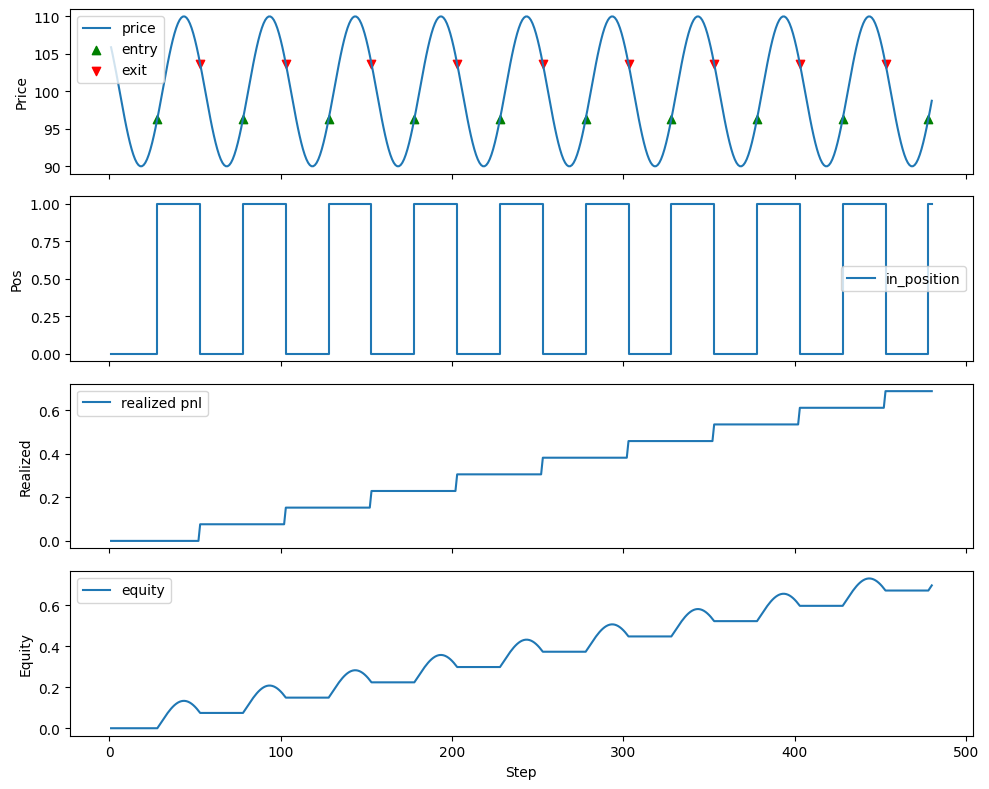

In [13]:
# Проверка среды на лонг стратегии

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from drive.MyDrive.stocks.pretrained_rl_ppo.scr.backtest_env import BacktestEnv, EnvConfig


def generate_sine_data(n=500, fast_window=5, slow_window=20):
    """Generate sinusoidal price data with moving averages and signals."""
    t = np.arange(n)
    price = 100 + 10 * np.sin(2 * np.pi * t / 50)
    df = pd.DataFrame({'close': price})
    df['fast_ma'] = df['close'].rolling(window=fast_window).mean()
    df['slow_ma'] = df['close'].rolling(window=slow_window).mean()
    df.dropna(inplace=True)
    fast = df['fast_ma']
    slow = df['slow_ma']
    signal = np.zeros(len(df), dtype=int)
    signal[(fast > slow) & (fast.shift(1) <= slow.shift(1))] = 1
    signal[(fast < slow) & (fast.shift(1) >= slow.shift(1))] = -1
    df['signal'] = signal
    return df.reset_index(drop=True)


def run_backtest(df, environment):
    env = environment
    env.reset()
    for sig in df['signal']:
        action = 0
        if sig == 1:
            action = 1
        elif sig == -1:
            action = 2
        _, _, done, _ = env.step(action)
        if done:
            break
    return env

LONG_CONFIG = EnvConfig(
    mode=1,          # работаем только от длинной позиции
    fee=0.00,         # без комиссии
    spread=0.000,      # без спреда
    leverage=1.0,    # без плеча
    max_steps=10**9, # практически бесконечный эпизод
    reward_scale=1.0,# без масштабирования вознаграждения
    use_log_reward=False, # линейная доходность
    time_penalty=0.0,     # нет штрафа за удержание
    hold_penalty=0.0,     # нет штрафа за бездействие
)

#проверка лонгов
df = generate_sine_data()
environment = BacktestEnv(df, feature_cols=['fast_ma', 'slow_ma'], cfg = LONG_CONFIG)
sim = run_backtest(df, environment)
logs = sim.logs()
print(logs.head(50).to_string())
fig = sim.plot()


     t       price  position  entry_price    reward    equity  realized_pnl  unrealized_pnl  opened  closed  exec_price  pnl_trade
0    1  105.877853         0     0.000000 -0.000000  0.000000      0.000000        0.000000   False   False    0.000000   0.000000
1    2  104.817537         0     0.000000 -0.000000  0.000000      0.000000        0.000000   False   False    0.000000   0.000000
2    3  103.681246        -1   103.681246 -0.000000  0.000000      0.000000       -0.000000    True   False  103.681246   0.000000
3    4  102.486899        -1   103.681246  0.011519  0.011519      0.000000        0.011519   False   False    0.000000   0.000000
4    5  101.253332        -1   103.681246  0.012036  0.023556      0.000000        0.023417   False   False    0.000000   0.000000
5    6  100.000000        -1   103.681246  0.012378  0.035934      0.000000        0.035505   False   False    0.000000   0.000000
6    7   98.746668        -1   103.681246  0.012533  0.048467      0.000000        

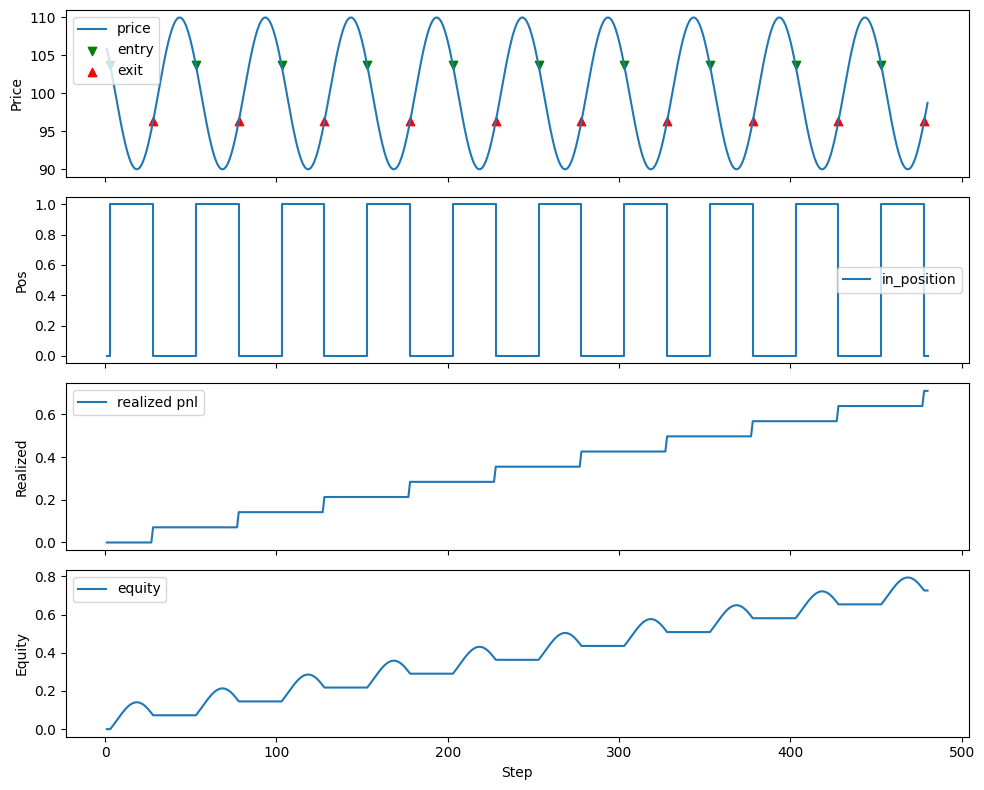

In [14]:
# Проверка среды на шорт стратегии

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from drive.MyDrive.stocks.pretrained_rl_ppo.scr.backtest_env import BacktestEnv, EnvConfig


def generate_sine_data(n=500, fast_window=5, slow_window=20):
    """Generate sinusoidal price data with moving averages and signals."""
    t = np.arange(n)
    price = 100 + 10 * np.sin(2 * np.pi * t / 50)
    df = pd.DataFrame({'close': price})
    df['fast_ma'] = df['close'].rolling(window=fast_window).mean()
    df['slow_ma'] = df['close'].rolling(window=slow_window).mean()
    df.dropna(inplace=True)
    fast = df['fast_ma']
    slow = df['slow_ma']
    signal = np.zeros(len(df), dtype=int)
    signal[(fast < slow) & (fast.shift(1) >= slow.shift(1))] = 1
    signal[(fast > slow) & (fast.shift(1) <= slow.shift(1))] = -1
    df['signal'] = signal
    return df.reset_index(drop=True)


def run_backtest(df, environment):
    env = environment
    env.reset()
    for sig in df['signal']:
        action = 0
        if sig == 1:
            action = 1
        elif sig == -1:
            action = 2
        _, _, done, _ = env.step(action)
        if done:
            break
    return env

SORT_CONFIG = EnvConfig(
    mode=-1,          # работаем только от длинной позиции
    fee=0.00,         # без комиссии
    spread=0.000,      # без спреда
    leverage=1.0,    # без плеча
    max_steps=10**9, # практически бесконечный эпизод
    reward_scale=1.0,# без масштабирования вознаграждения
    use_log_reward=False, # линейная доходность
    time_penalty=0.0,     # нет штрафа за удержание
    hold_penalty=0.0,     # нет штрафа за бездействие
)

#проверка лонгов
df = generate_sine_data()
environment = BacktestEnv(df, feature_cols=['fast_ma', 'slow_ma'], cfg = SORT_CONFIG)
sim = run_backtest(df, environment)
logs = sim.logs()
print(logs.head(50).to_string())
fig = sim.plot()
